# 🔌 Power Consumption Analysis of a Custom Robotic Arm

This notebook analyzes the power consumption of an n-DOF robotic arm,
where each joint may be equipped with a different servomotor model.

The structure of the robotic arm, including servomotor references and operation torques,
is defined in the Excel file: `Robotic_arm_motors.xlsx`.

Two supporting modules are used:
- `Functions/servomotors.py`: Loads servomotor data and builds approximation models.
- `Functions/robotic_arm.py`: Uses that data to simulate the robotic arm's behavior.


## 📦 Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Functions.robotic_arm import robotic_arm


## 🤖 Instantiate the Robotic Arm Object

In [ ]:
arm = robotic_arm()

C:\Users\tilag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


## ⚙️ Evaluate the Robotic Arm Under Different Operation Cases

1. **User-defined operation torque**
2. **Rated operation from datasheets**
3. **Rated operation with safety margin**
4. **Operation at maximum capacity**


In [ ]:
servos_op, arm_operation = arm.operation_point()
servos_rated, arm_rated = arm.rated_point()
servos_safe, arm_safe = arm.safe_point()
servos_max, arm_max = arm.max_point()


## 🧾 Generate Consolidated Report

In [ ]:
print("="*90)
print("🔧 Robotic Arm - Operating at Edge Conditions:")
print(servos_op)
print("-"*90)
print("✅ Robotic Arm - Rated Operation:")
print(servos_rated)
print("-"*90)
print("🛡️ Robotic Arm - Rated Operation + Safety Factor:")
print(servos_safe)
print("-"*90)
print("⚡ Robotic Arm - Maximum Capacity:")
print(servos_max)

# Combine all cases into a single DataFrame for easy comparison
arm_report_df = pd.concat([arm_operation, arm_rated, arm_safe, arm_max], axis=1)
print("-"*90)
print("📊 Summary: Robotic Arm Operating Points")
print(arm_report_df)


🔧 Robotic Arm - Operating at Edge Conditions:
    T(N.m)    N(r/min)    Pout(W)       U(V)      I(A)      Pin(W)     Eff(%)
M1   10.46   78.622218  86.105066  23.739290  6.547546  155.766765  55.388325
M2    6.84   80.447454  57.659892  23.819398  4.447939  106.308889  54.340283
M3    9.33   79.174450  77.181956  23.764009  5.885070  140.471773  55.192594
M4    6.31   80.722488  53.455138  23.831291  4.145786   98.938446  54.034459
M5    4.00   81.889546  34.340547  23.883198  2.810050   66.420353  51.061518
M6    2.04  141.970579  30.213892  24.493458  2.730588   66.778237  44.929660
M7    0.65  142.026881   9.508834  24.539760  1.605754   39.419375  24.169604
------------------------------------------------------------------------------------------
✅ Robotic Arm - Rated Operation:
    T(N.m)    N(r/min)    Pout(W)       U(V)      I(A)      Pin(W)     Eff(%)
M1    10.5   78.603113  86.420768  23.738421  6.571077  156.306237  55.393182
M2    10.5   78.603113  86.420768  23.738421  6.57

## 🔋 Determine Power Supply Requirements Based on Safety Margin

In [ ]:
safe_I = arm_report_df.loc["I(A)", "Rated with safety factor"]
safe_P = arm_report_df.loc["P(W)", "Rated with safety factor"]
op_I = arm_report_df.loc["I(A)", "Operation"]
op_P = arm_report_df.loc["P(W)", "Operation"]
rated_I = arm_report_df.loc["I(A)", "Rated"]
rated_P = arm_report_df.loc["P(W)", "Rated"]

print("-"*90)
print(f"🔌 Power Source Requirements (with safety factor):")
print(f"- Output voltage: 24 VDC (stable)")
print(f"- Output current ≥ {safe_I:.2f} A")
print(f"- Output power ≥ {max(safe_P, safe_I * 24):.2f} W")

# === Safety Warning Messages ===
if op_I > safe_I or op_P > safe_P:
    print(f"💥 WARNING: Operating point exceeds safe design limits!")
    print(f"  - Current: {op_I:.2f} A > Safe: {safe_I:.2f} A")
    print(f"  - Power  : {op_P:.2f} W > Safe: {safe_P:.2f} W")

elif op_I > rated_I or op_P > rated_P:
    print(f"⚠️ WARNING: Operating point exceeds rated values.")
    print(f"  - Current: {op_I:.2f} A > Rated: {rated_I:.2f} A")
    print(f"  - Power  : {op_P:.2f} W > Rated: {rated_P:.2f} W")

print("="*90)


------------------------------------------------------------------------------------------
🔌 Power Source Requirements (with safety factor):
- Output voltage: 24 VDC (stable)
- Output current ≥ 47.01 A
- Output power ≥ 1128.15 W


## 📉 Visualization: Current and Power Consumption per Operation Case

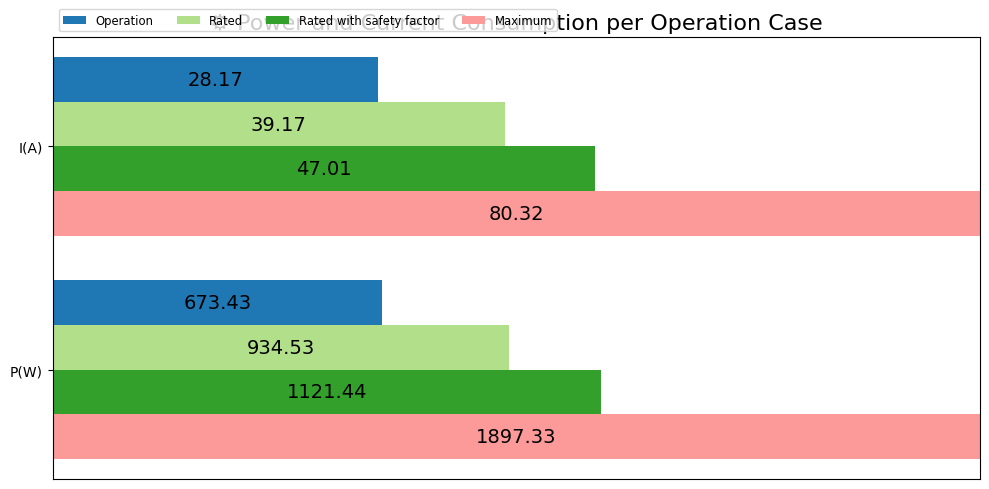

In [ ]:
category_names = ['Operation', 'Rated', 'Rated with safety factor', 'Maximum']
report_subset = arm_report_df.loc[["I(A)", "P(W)"]]

# Normalize values for plotting
raw_data = report_subset.values
data_max = np.max(raw_data, axis=1).reshape(-1, 1)
normalized = raw_data / data_max

# Bar chart settings
index = np.arange(normalized.shape[0])
bar_height = 0.2
category_colors = plt.colormaps['Paired'](np.linspace(0.15, 0.41, len(category_names)))

fig, ax = plt.subplots(figsize=(10, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, 1)

for j in range(len(category_names)):
    bars = ax.barh(index + j * bar_height, normalized[:, j], height=bar_height,
                   color=category_colors[j], label=category_names[j])
    labels = [f"{v:.2f}" for v in raw_data[:, j]]
    ax.bar_label(bars, labels=labels, label_type='center', fontsize=14, color='black')

ax.set_yticks(index + (bar_height * (len(category_names) - 1)) / 2)
ax.set_yticklabels(report_subset.index)
ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

plt.title('⚙️ Power and Current Consumption per Operation Case', fontsize=16)
plt.tight_layout()
plt.show()


## 📌 Conclusion

This analysis provides an overview of the estimated electrical consumption of the robotic arm under different scenarios.

- The **safest configuration** (Rated + Safety Factor) should be used for power supply sizing.
- Operation outside of rated conditions is **not recommended** due to the potential for overheating or overloading.
- Graphical comparison helps visualize how far each condition is from the rated point.

**Next steps:**
- Modeling dynamic consumption under motion profiles.
- Thermal analysis and heat dissipation needs.
- Hardware-in-the-loop verification with actual servomotor behavior.
